# Gaussian Process Classification: From Continuous Functions to Discrete Outcomes

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 14 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

Throughout our exploration of Gaussian Processes, we've focused on regression tasks—modeling continuous outputs like stellar radial velocities or interpolating light curves. GPs provided flexible function approximation without requiring explicit feature engineering. The kernel function encoded our assumptions about smoothness and correlation structure, while the data determined the actual function values.

Yet many astronomical problems require classification rather than regression. We need to distinguish stars from galaxies in photometric surveys or classify variable objects by their light curve morphology. These tasks involve discrete outcomes—an object either belongs to a class or it doesn't—which cannot be directly modeled with the continuous Gaussian distributions at the heart of GP regression.

The challenge parallels one we've encountered before. When extending linear regression to classification problems, we introduced the logistic sigmoid function to map continuous values to probabilities. Gaussian Process Classification employs the same strategy but with a key modification: instead of a linear function inside the sigmoid, we use a flexible function drawn from a Gaussian Process. This modification enables nonlinear decision boundaries that adapt to data complexity, uncertainty quantification that naturally increases in sparse regions, and a principled framework for incorporating prior knowledge through kernel design.

Consider the task of separating stars from galaxies using photometric data. While logistic regression constrains us to linear boundaries in feature space (or requires manual feature engineering), GP classification can discover complex curved boundaries that respect the true astrophysical distinctions between these populations. In regions where populations overlap or training data is sparse, the model automatically expresses appropriate uncertainty rather than making overconfident predictions.

The mathematical framework builds naturally on concepts we've already developed. We place a Gaussian Process prior on a latent function—often called the logit function—that represents the "score" for class membership. The sigmoid transformation converts these continuous scores to class probabilities. The key computational challenge is that observing discrete class labels rather than continuous function values breaks the convenient conjugacy properties that made GP regression tractable. We'll address this through the Laplace approximation, using the same mathematical tools we developed for Bayesian logistic regression but now applied to infinite-dimensional function spaces.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Gaussian Process Regression**: Understanding of kernels, covariance functions, and GP predictions from Chapter 14
- **Logistic Regression**: The sigmoid function and its role in classification from Chapter 7
- **Bayesian Logistic Regression**: The Laplace approximation and probit approximation from Chapter 9
- **Matrix Operations**: Eigenvalues, matrix inversions, and Cholesky decompositions
- **Optimization**: Gradient-based methods and convexity concepts

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Extending GPs to Classification**: Understanding how continuous GP outputs map to discrete class labels through link functions
- **Handling Non-Conjugate Inference**: Implementing the Laplace approximation for non-Gaussian posteriors
- **Nonlinear Decision Boundaries**: Learning complex classification boundaries directly from data without explicit feature engineering
- **Uncertainty Propagation**: Computing how latent function uncertainty translates to classification uncertainty
- **Kernel Selection**: Choosing appropriate kernels for classification tasks based on problem structure
- **Computational Implementation**: Efficiently computing GP classification predictions using matrix operations


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split

# Configure plotting parameters to match textbook style
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)

%matplotlib inline

## From Linear to Nonlinear Decision Boundaries

To understand the motivation for Gaussian Process Classification, let's examine a fundamental problem in astronomical surveys: separating stars from galaxies using photometric colors. This classification task lies at the heart of many astronomical analyses, from studying galactic structure using stellar populations to measuring cosmological parameters through galaxy clustering.

In photometric surveys, we often rely on color indices—differences between magnitudes in various filters—to distinguish stellar from extragalactic sources. Stars follow well-defined sequences in color-color space based on their temperatures and metallicities, while galaxies occupy different regions due to their composite stellar populations and redshift effects. The boundary between these populations is rarely linear—it curves through color space following the edges of the stellar locus and the distribution of galaxy spectral energy distributions.

Let's load a dataset that captures these characteristics and visualize why linear classification methods prove inadequate for this problem:

In [2]:
# Load the star-galaxy dataset
data = np.load("dataset_gaia_star_galaxy.npz")
X = np.vstack([data['bp_rp'], data['g_rp']]).T  # Feature matrix: BP-RP and G-RP colors
t = data['star_label']  # Labels: 1 for stars, 0 for galaxies

# Split into training and test sets
X_train, X_test, t_train, t_test = train_test_split(
    X, t, test_size=0.2, random_state=42, stratify=t
)

print("Star-Galaxy Dataset Characteristics:")
print("-" * 50)
print(f"Total objects: {len(t)}")
print(f"Stars: {np.sum(t == 1)} ({100*np.sum(t == 1)/len(t):.1f}%)")
print(f"Galaxies: {np.sum(t == 0)} ({100*np.sum(t == 0)/len(t):.1f}%)")
print(f"\nTraining set: {len(t_train)} objects")
print(f"Test set: {len(t_test)} objects")
print(f"\nFeatures: BP-RP color, G-RP color (Gaia photometry)")

Star-Galaxy Dataset Characteristics:
--------------------------------------------------
Total objects: 537
Stars: 238 (44.3%)
Galaxies: 299 (55.7%)

Training set: 429 objects
Test set: 108 objects

Features: BP-RP color, G-RP color (Gaia photometry)


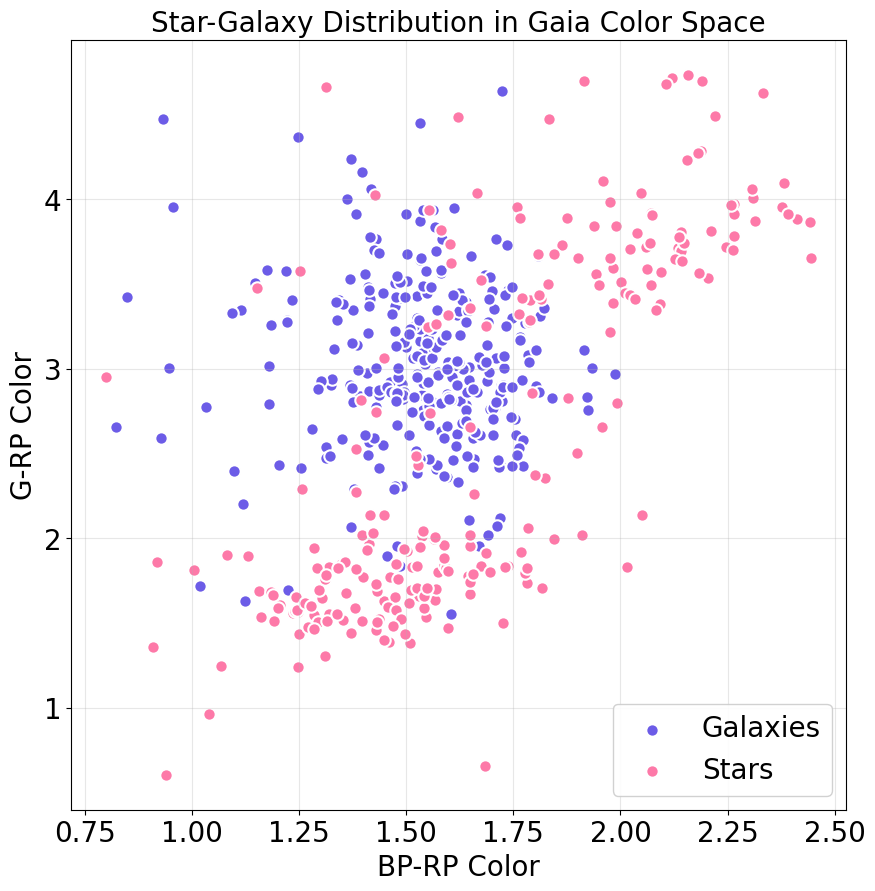

In [3]:
# Visualize the star-galaxy distribution in color space
plt.figure(figsize=(10, 10))

# Define color palette for better visualization
galaxy_color = '#6C5CE7'  # Soft purple
star_color = '#FD79A8'    # Warm pink

# Plot galaxies (class 0) 
plt.scatter(X[t == 0, 0], X[t == 0, 1], 
           s=80, color=galaxy_color, alpha=1.0, 
           edgecolors='white', linewidth=1.5,
           label='Galaxies')

# Plot stars (class 1)
plt.scatter(X[t == 1, 0], X[t == 1, 1], 
           s=80, color=star_color, alpha=1.0,
           edgecolors='white', linewidth=1.5,
           label='Stars')

plt.xlabel('BP-RP Color')
plt.ylabel('G-RP Color')
plt.title('Star-Galaxy Distribution in Gaia Color Space')
plt.legend(frameon=True, fancybox=True, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.show()

The visualization reveals the complexity of star-galaxy separation in color space. While there are regions where stars and galaxies cluster separately, the boundary between them is clearly nonlinear. Notice how galaxies tend to occupy bluer regions (lower BP-RP values) while stars spread across a wider range of colors. The overlap region presents the greatest classification challenge—these objects could plausibly belong to either category.

This nonlinear boundary exemplifies why simple linear classifiers fall short. A logistic regression model would attempt to separate these populations with a straight line, inevitably misclassifying objects near the curved true boundary. Gaussian Process Classification, by contrast, can learn flexible decision boundaries that adapt to the data's natural structure.

The overlap between populations also highlights the importance of probabilistic predictions. For objects in the ambiguous region, we should not force a hard classification but rather quantify our uncertainty. This uncertainty can guide follow-up observations—objects with classification probabilities near 0.5 warrant spectroscopic confirmation.

## The Limitations of Linear Classification

Before diving into Gaussian Process Classification, let's first understand why linear methods prove inadequate for this problem. By implementing standard logistic regression, we can visualize its decision boundary and appreciate the need for more flexible approaches.

Linear logistic regression models the probability of being a star as:

$$p(t=1|\mathbf{x}, \mathbf{w}) = \sigma(\mathbf{w}^T\mathbf{x} + b)$$

where $\mathbf{w}$ are the weights, $b$ is the bias term, and $\sigma$ is the sigmoid function. This formulation constrains the decision boundary to be a straight line in our two-dimensional color space.

In [4]:
from sklearn.linear_model import LogisticRegression

# Fit a standard logistic regression model
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, t_train)

# Create a grid for visualization
n_grid = 100
bp_rp_range = np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, n_grid)
g_rp_range = np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, n_grid)
bp_rp_grid, g_rp_grid = np.meshgrid(bp_rp_range, g_rp_range)
X_grid = np.column_stack([bp_rp_grid.ravel(), g_rp_grid.ravel()])

# Compute logistic regression predictions on the grid
lr_probs = lr_model.predict_proba(X_grid)[:, 1]
lr_probs_grid = lr_probs.reshape(n_grid, n_grid)

# Evaluate on test set
lr_test_probs = lr_model.predict_proba(X_test)[:, 1]
lr_test_pred = (lr_test_probs > 0.5).astype(int)
lr_accuracy = np.mean(lr_test_pred == t_test)

print(f"Logistic Regression Test Accuracy: {lr_accuracy:.3f}")

Logistic Regression Test Accuracy: 0.759


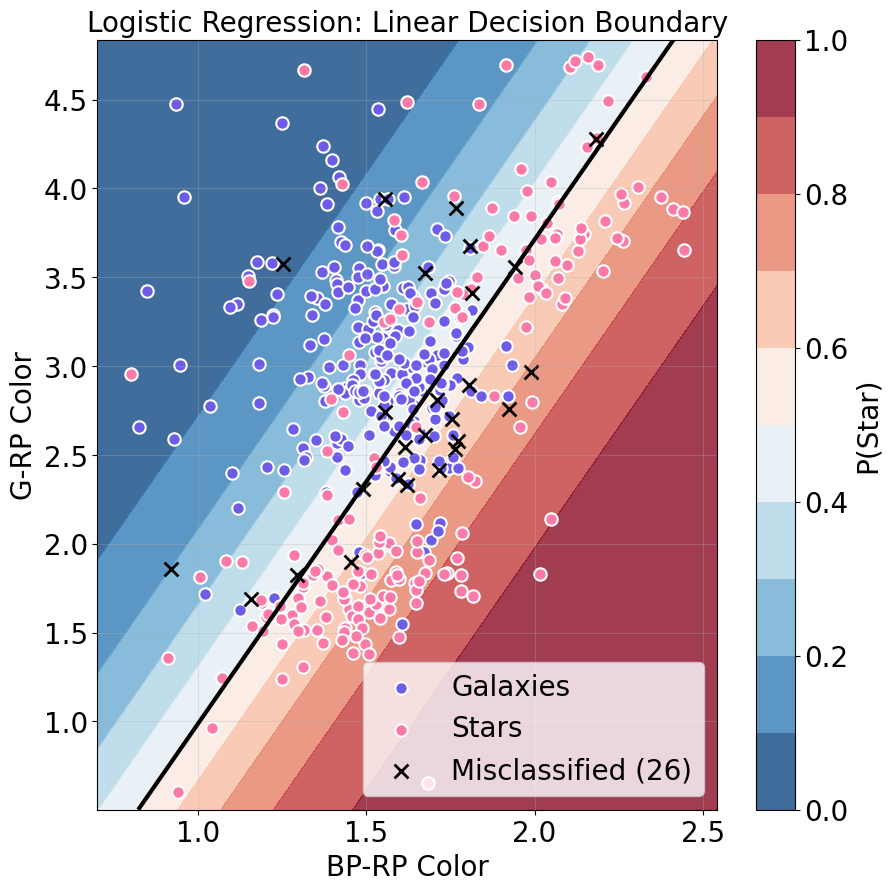

In [5]:
# Visualize logistic regression decision boundary
plt.figure(figsize=(10, 10))

# Plot probability contours
contour = plt.contourf(bp_rp_grid, g_rp_grid, lr_probs_grid, 
                      levels=np.linspace(0, 1, 11), 
                      cmap='RdBu_r', alpha=0.8)
plt.colorbar(contour, label='P(Star)')

# Plot training data
plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
           s=80, color=galaxy_color, alpha=1.0,
           edgecolors='white', linewidth=1.5, label='Galaxies')
plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
           s=80, color=star_color, alpha=1.0,
           edgecolors='white', linewidth=1.5, label='Stars')

# Draw the linear decision boundary
plt.contour(bp_rp_grid, g_rp_grid, lr_probs_grid, 
           levels=[0.5], colors='black', linewidths=3, linestyles='solid')

# Highlight misclassified test points
misclassified = lr_test_pred != t_test
plt.scatter(X_test[misclassified, 0], X_test[misclassified, 1],
           s=100, marker='x', color='black', linewidth=2,
           label=f'Misclassified ({np.sum(misclassified)})')

plt.xlabel('BP-RP Color')
plt.ylabel('G-RP Color')
plt.title('Logistic Regression: Linear Decision Boundary')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The linear decision boundary clearly struggles to separate the two populations effectively. Notice how the straight line cannot adapt to the curved distribution of stars and galaxies in color space. Many objects are misclassified simply because the model lacks the flexibility to learn a more appropriate boundary.

This limitation motivates Gaussian Process Classification. By replacing the linear function $\mathbf{w}^T\mathbf{x}$ with a flexible function drawn from a Gaussian Process, we can learn decision boundaries that adapt to the true complexity of the data.

## The Latent Function Approach

The key insight of Gaussian Process Classification is to introduce a latent continuous function that connects our input features to class probabilities. Instead of directly modeling discrete class labels, we model a continuous "score" function that gets transformed into probabilities.

For a given input $\mathbf{x}$, we define:
1. A latent function value: $a(\mathbf{x})$ (can be any real number)
2. A class probability: $p(t=1|\mathbf{x}) = \sigma(a(\mathbf{x}))$ (between 0 and 1)

We place a Gaussian Process prior on the latent function:

$$a(\mathbf{x}) \sim \mathcal{GP}(0, k(\mathbf{x}, \mathbf{x}'))$$

This allows the latent function—and therefore the decision boundary—to be as complex as the data requires, while still maintaining the probabilistic framework that enables uncertainty quantification.

## Implementing the Core Components

To implement GP classification, we need several key components. Let's build them systematically, starting with the kernel function that encodes our assumptions about similarity in color space.

The squared exponential (RBF) kernel assumes that objects with similar colors should have similar classifications:

$$k(\mathbf{x}, \mathbf{x}') = \sigma_f^2 \exp\left(-\frac{||\mathbf{x} - \mathbf{x}'||^2}{2\ell^2}\right)$$

where $\sigma_f^2$ is the signal variance and $\ell$ is the length scale. The length scale controls how rapidly the classification function can vary—smaller values allow more complex boundaries.

In [6]:
def rbf_kernel(X1, X2, length_scale=1.0, amplitude=1.0):
    """
    Compute the RBF (squared exponential) kernel matrix.
    
    Parameters
    ----------
    X1 : array, shape (n1, d)
        First set of input points
    X2 : array, shape (n2, d)
        Second set of input points
    length_scale : float
        Controls the smoothness of the function
    amplitude : float
        Controls the vertical scale of the function
        
    Returns
    -------
    K : array, shape (n1, n2)
        Kernel matrix
    """
    # Compute squared Euclidean distances efficiently
    # Using the expansion: ||x - y||^2 = ||x||^2 + ||y||^2 - 2x^T y
    X1_sqnorms = np.sum(X1**2, axis=1, keepdims=True)
    X2_sqnorms = np.sum(X2**2, axis=1, keepdims=True)
    sqdist = X1_sqnorms + X2_sqnorms.T - 2 * np.dot(X1, X2.T)
    
    # Ensure numerical stability (distances should be non-negative)
    sqdist = np.maximum(sqdist, 0)
    
    # Apply RBF transformation
    K = amplitude * np.exp(-0.5 * sqdist / length_scale**2)
    
    return K

def sigmoid(a):
    """
    Sigmoid function
    
    Parameters
    ----------
    a : array
        Input values (logits)
        
    Returns
    -------
    array
        Sigmoid outputs between 0 and 1
    """
    return 1 / (1 + np.exp(-np.clip(a, -500, 500)))

## Finding the MAP Estimate via the Laplace Approximation

The core challenge in GP classification is inferring the latent function values at our training points. Unlike GP regression where we observe noisy function values directly, here we only see discrete class labels. We need to find the latent values that best explain these observations.

The posterior distribution over latent values combines our GP prior with the likelihood of observed labels:

$$p(\mathbf{a}|\mathbf{X}, \mathbf{t}) \propto p(\mathbf{t}|\mathbf{a}) p(\mathbf{a}|\mathbf{X})$$

where:
- $p(\mathbf{a}|\mathbf{X}) = \mathcal{N}(\mathbf{0}, \mathbf{K})$ is the GP prior
- $p(\mathbf{t}|\mathbf{a}) = \prod_{i=1}^N \sigma(a_i)^{t_i}(1-\sigma(a_i))^{1-t_i}$ is the likelihood

Due to the nonlinear sigmoid function, this posterior is not Gaussian. The Laplace approximation addresses this by finding the mode (MAP estimate) and approximating the distribution as Gaussian around that mode.

To find the MAP estimate, we maximize the log posterior:

$$\mathbf{a}_{\text{MAP}} = \arg\max_{\mathbf{a}} \left[ \sum_{i=1}^N \left(t_i \log \sigma(a_i) + (1-t_i)\log(1-\sigma(a_i))\right) - \frac{1}{2}\mathbf{a}^T\mathbf{K}^{-1}\mathbf{a} \right]$$


## Finding the MAP Estimate via Fixed-Point Iteration

The core computational challenge in GP classification is finding the MAP estimate of the latent function values. Since we only observe discrete labels rather than continuous function values, we need to solve an optimization problem to infer the most probable latent values given our observations.

The MAP estimate satisfies the following condition (derived from setting the gradient of the log posterior to zero):

$$\mathbf{t} - \boldsymbol{\sigma}(\mathbf{a}) - \mathbf{K}^{-1}\mathbf{a} = \mathbf{0}$$

Rearranging this equation yields:

$$\mathbf{a} = \mathbf{K}(\mathbf{t} - \boldsymbol{\sigma}(\mathbf{a}))$$

This is a fixed-point equation—$\mathbf{a}$ appears on both sides. We can solve it iteratively:

$$\mathbf{a}^{(k+1)} = \mathbf{K}(\mathbf{t} - \boldsymbol{\sigma}(\mathbf{a}^{(k)}))$$

This iteration has an elegant interpretation: at each step, we compute the residuals $\mathbf{t} - \boldsymbol{\sigma}(\mathbf{a})$ between true labels and current predictions, then smooth these residuals using the kernel matrix. The kernel acts as a regularizer, ensuring nearby points have similar latent values.

However, direct iteration can be unstable, especially when the kernel matrix has large eigenvalues. To improve convergence, we introduce damping:

$$\mathbf{a}^{(k+1)} = (1-\lambda)\mathbf{a}^{(k)} + \lambda \mathbf{K}(\mathbf{t} - \boldsymbol{\sigma}(\mathbf{a}^{(k)}))$$

where $\lambda \in (0,1]$ is the damping factor. Smaller values lead to more stable but slower convergence. The damping prevents overshooting by blending the new estimate with the previous one.

For interested readers, more sophisticated optimization methods like Newton's method can achieve faster convergence by utilizing second-order information (the Hessian matrix). However, the simplicity and stability of damped fixed-point iteration make it an excellent choice for many practical applications.

In [7]:
def find_map_estimate_damped(K, t, damping=0.01, max_iter=5000, tol=1e-4):
    """
    Find the MAP estimate using damped fixed-point iteration.
    
    Parameters
    ----------
    K : array, shape (n, n)
        Kernel matrix at training points
    t : array, shape (n,)
        Binary training labels
    damping : float
        Damping factor (0 < damping <= 1)
    max_iter : int
        Maximum number of iterations
    tol : float
        Convergence tolerance
        
    Returns
    -------
    a_map : array, shape (n,)
        MAP estimate of latent function values
    converged : bool
        Whether the algorithm converged
    """
    n = len(t)
    a = np.zeros(n)  # Initialize at zero
    
    # Add small diagonal term for numerical stability
    K_stable = K + 1e-6 * np.eye(n)
    
    for iteration in range(max_iter):
        # Store old values for convergence check
        a_old = a.copy()
        
        # Compute sigmoid values
        sigma_a = sigmoid(a)
        
        # Fixed-point update with damping
        a_new = K_stable @ (t - sigma_a)
        a = (1 - damping) * a + damping * a_new
        
        # Check convergence
        if np.linalg.norm(a - a_old) < tol:
            return a, True
    
    return a, False

# Normalize features for numerical stability
X_mean = X_train.mean(axis=0)
X_std = X_train.std(axis=0)
X_train_norm = (X_train - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

# Set kernel hyperparameters
length_scale = 0.3  # Smaller length scale for better convergence
amplitude = 1.0

# Compute kernel matrix for training data
K_train = rbf_kernel(X_train_norm, X_train_norm, length_scale, amplitude)

# Find MAP estimate
print("Finding MAP estimate...")
a_map, converged = find_map_estimate_damped(K_train, t_train, damping=0.01, max_iter=5000)

if converged:
    print("MAP estimation converged successfully")
else:
    print("Warning: MAP estimation did not converge")

Finding MAP estimate...
MAP estimation converged successfully


## Computing the Predictive Distribution

With the MAP estimate in hand, we can now make predictions for new points. The Laplace approximation gives us a Gaussian approximation to the posterior distribution over latent values:

$$p(\mathbf{a}|\mathbf{X}, \mathbf{t}) \approx \mathcal{N}(\mathbf{a}|\mathbf{a}_{\text{MAP}}, \mathbf{H}^{-1})$$

where the Hessian matrix is:

$$\mathbf{H} = \mathbf{W} + \mathbf{K}^{-1}$$

with $\mathbf{W} = \text{diag}(\sigma(a_1)(1-\sigma(a_1)), \ldots, \sigma(a_N)(1-\sigma(a_N)))$ containing the second derivatives of the negative log-likelihood.

For a test point $\mathbf{x}_*$, the predictive distribution of the latent value is approximately Gaussian:

$$p(a_*|\mathbf{x}_*, \mathbf{X}, \mathbf{t}) \approx \mathcal{N}(a_*|\mu_*, \sigma_*^2)$$

where:
- $\mu_* = \mathbf{k}_*^T (\mathbf{t} - \boldsymbol{\sigma}(\mathbf{a}_{\text{MAP}}))$
- $\sigma_*^2 = k_{**} - \mathbf{k}_*^T (\mathbf{W}^{-1} + \mathbf{K})^{-1} \mathbf{k}_*$

Here $\mathbf{k}_* = k(\mathbf{x}_*, \mathbf{X})$ is the vector of kernel values between the test point and training points, and $k_{**} = k(\mathbf{x}_*, \mathbf{x}_*)$ is the prior variance at the test point.

The mean prediction represents a weighted combination of residuals at training points. Points where the model's prediction differs from the true label contribute more strongly to predictions at nearby test points. The variance captures our uncertainty about the latent function value, accounting for both the distance to training data and the local curvature of the likelihood.

In [8]:
def predict_gpc(X_train, t_train, X_test, a_map, kernel_func, length_scale=1.0, amplitude=1.0):
    """
    Compute predictive distribution for Gaussian Process Classification.
    
    Parameters
    ----------
    X_train : array, shape (n_train, d)
        Training features
    t_train : array, shape (n_train,)
        Training labels
    X_test : array, shape (n_test, d)
        Test features
    a_map : array, shape (n_train,)
        MAP estimate of latent values
    kernel_func : function
        Kernel function
    length_scale : float
        Kernel length scale
    amplitude : float
        Kernel amplitude
        
    Returns
    -------
    mu_star : array, shape (n_test,)
        Mean predictions (latent space)
    var_star : array, shape (n_test,)
        Predictive variances (latent space)
    p_star : array, shape (n_test,)
        Class probabilities
    """
    n_train = X_train.shape[0]
    n_test = X_test.shape[0]
    
    # Compute kernel matrices
    K = kernel_func(X_train, X_train, length_scale, amplitude) + 1e-6 * np.eye(n_train)
    k_star = kernel_func(X_test, X_train, length_scale, amplitude)
    k_star_star = kernel_func(X_test, X_test, length_scale, amplitude)
    
    # Compute sigmoid values at MAP estimate
    sigma_a = sigmoid(a_map)
    
    # Mean prediction
    mu_star = k_star @ (t_train - sigma_a)
    
    # Compute W matrix for variance prediction
    W = np.diag(sigma_a * (1 - sigma_a))
    
    # Variance prediction using Woodbury matrix identity
    # var_star = k_{**} - k_*^T (W^{-1} + K)^{-1} k_*
    W_inv = np.diag(1.0 / (sigma_a * (1 - sigma_a) + 1e-6))  # Add small term for stability
    var_star = np.diag(k_star_star) - np.sum(k_star * 
                                             np.linalg.solve(W_inv + K, k_star.T).T, 
                                             axis=1)
    
    # Convert to class probabilities using probit approximation
    # This accounts for uncertainty in the latent function
    kappa = 1.0 / np.sqrt(1.0 + np.pi * var_star / 8.0)
    p_star = sigmoid(kappa * mu_star)
    
    return mu_star, var_star, p_star

## Visualizing GP Classification Results

Now we can apply our GP classifier to visualize how it separates stars and galaxies in color space. We'll create a dense grid of points and compute predictions to see both the decision boundary and the model's confidence across the feature space.

The key insight is that GP classification provides not just a single decision boundary but a full probabilistic prediction at each point. This allows us to visualize regions of high confidence versus regions where the model is uncertain about the classification.

In [9]:
# Create a grid for visualization
n_grid = 100
bp_rp_range = np.linspace(X[:, 0].min() - 0.1, X[:, 0].max() + 0.1, n_grid)
g_rp_range = np.linspace(X[:, 1].min() - 0.1, X[:, 1].max() + 0.1, n_grid)
bp_rp_grid, g_rp_grid = np.meshgrid(bp_rp_range, g_rp_range)

# Normalize grid points
X_grid = np.column_stack([bp_rp_grid.ravel(), g_rp_grid.ravel()])
X_grid_norm = (X_grid - X_mean) / X_std

# Compute predictions on the grid
print("Computing predictions on grid...")
mu_grid, var_grid, p_grid = predict_gpc(
    X_train_norm, t_train, X_grid_norm, a_map, rbf_kernel, 
    length_scale=length_scale, amplitude=amplitude
)

# Reshape for plotting
p_grid = p_grid.reshape(n_grid, n_grid)
var_grid = var_grid.reshape(n_grid, n_grid)

# Make predictions on test set
mu_test, var_test, p_test = predict_gpc(
    X_train_norm, t_train, X_test_norm, a_map, rbf_kernel,
    length_scale=length_scale, amplitude=amplitude
)

# Binary predictions
t_pred = (p_test > 0.5).astype(int)

# Compute accuracy
accuracy = np.mean(t_pred == t_test)
print(f"\nGP Classification Test Accuracy: {accuracy:.3f}")
print(f"Logistic Regression Test Accuracy: {lr_accuracy:.3f}")
print(f"Improvement: {accuracy - lr_accuracy:.3f}")

Computing predictions on grid...

GP Classification Test Accuracy: 0.898
Logistic Regression Test Accuracy: 0.759
Improvement: 0.139


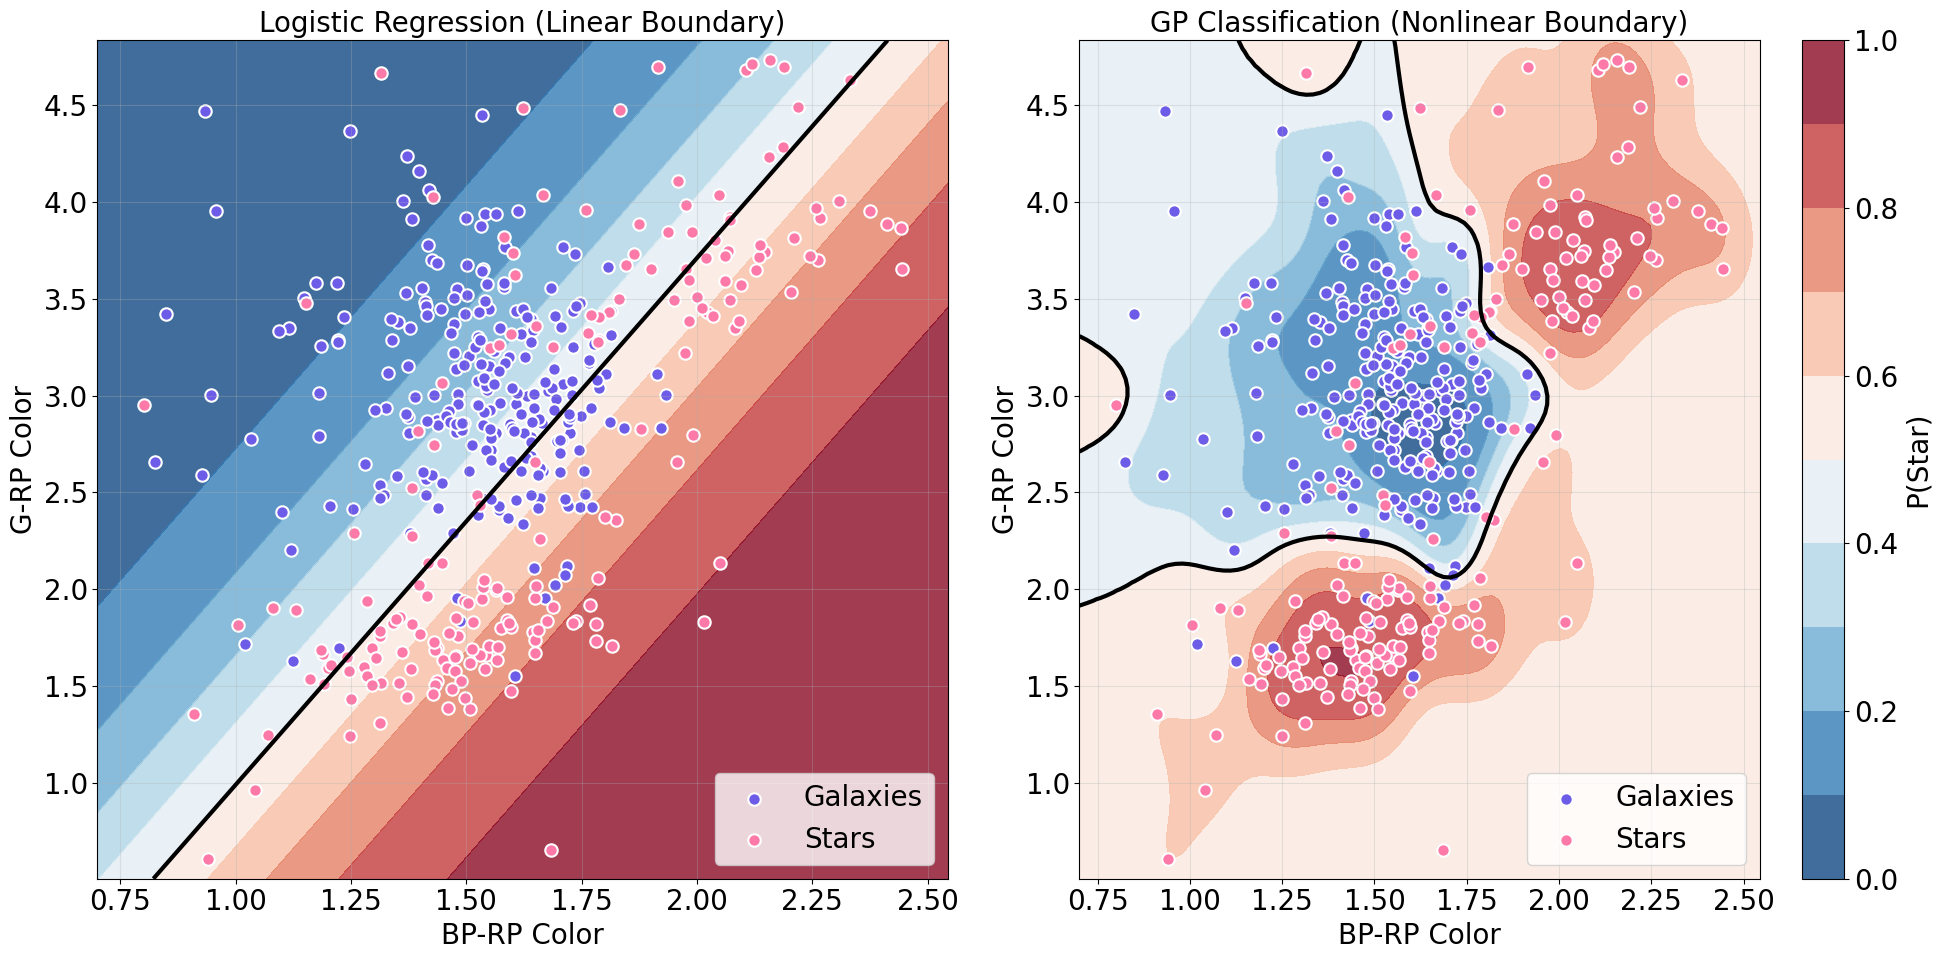

In [10]:
# Create side-by-side comparison of Logistic Regression vs GP Classification
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left panel: Logistic Regression
ax = axes[0]
contour = ax.contourf(bp_rp_grid, g_rp_grid, lr_probs_grid, 
                      levels=np.linspace(0, 1, 11), 
                      cmap='RdBu_r', alpha=0.8)
ax.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
          s=80, color=galaxy_color, alpha=1.0,
          edgecolors='white', linewidth=1.5, label='Galaxies')
ax.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
          s=80, color=star_color, alpha=1.0,
          edgecolors='white', linewidth=1.5, label='Stars')
ax.contour(bp_rp_grid, g_rp_grid, lr_probs_grid, 
          levels=[0.5], colors='black', linewidths=3)
ax.set_xlabel('BP-RP Color')
ax.set_ylabel('G-RP Color')
ax.set_title('Logistic Regression (Linear Boundary)')
ax.legend()
ax.grid(True, alpha=0.3)

# Right panel: GP Classification
ax = axes[1]
contour = ax.contourf(bp_rp_grid, g_rp_grid, p_grid, 
                      levels=np.linspace(0, 1, 11), 
                      cmap='RdBu_r', alpha=0.8)
plt.colorbar(contour, ax=ax, label='P(Star)')
ax.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
          s=80, color=galaxy_color, alpha=1.0,
          edgecolors='white', linewidth=1.5, label='Galaxies')
ax.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
          s=80, color=star_color, alpha=1.0,
          edgecolors='white', linewidth=1.5, label='Stars')
ax.contour(bp_rp_grid, g_rp_grid, p_grid, 
          levels=[0.5], colors='black', linewidths=3)
ax.set_xlabel('BP-RP Color')
ax.set_ylabel('G-RP Color')
ax.set_title('GP Classification (Nonlinear Boundary)')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The comparison clearly demonstrates the power of Gaussian Process Classification. While logistic regression is constrained to a linear decision boundary that cuts diagonally through the data, GP classification learns a flexible boundary that adapts to the true distribution of stars and galaxies in color space.

Notice several key features of the GP classification:

1. **Adaptive Complexity**: The decision boundary curves naturally around clusters of data, creating a more complex separation in regions with mixed populations and simpler boundaries where the classes are well-separated.

2. **Smooth Transitions**: The probability contours show gradual transitions from high confidence regions (deep blue for galaxies, deep red for stars) to uncertain regions near the boundary, reflecting the continuous nature of the underlying latent function.

3. **Data-Driven Shape**: The boundary respects the actual distribution of objects rather than imposing a predetermined linear form. This is particularly evident in how it curves to accommodate the galaxy population in the upper-left region.

Let's now examine the uncertainty quantification that GP classification provides:

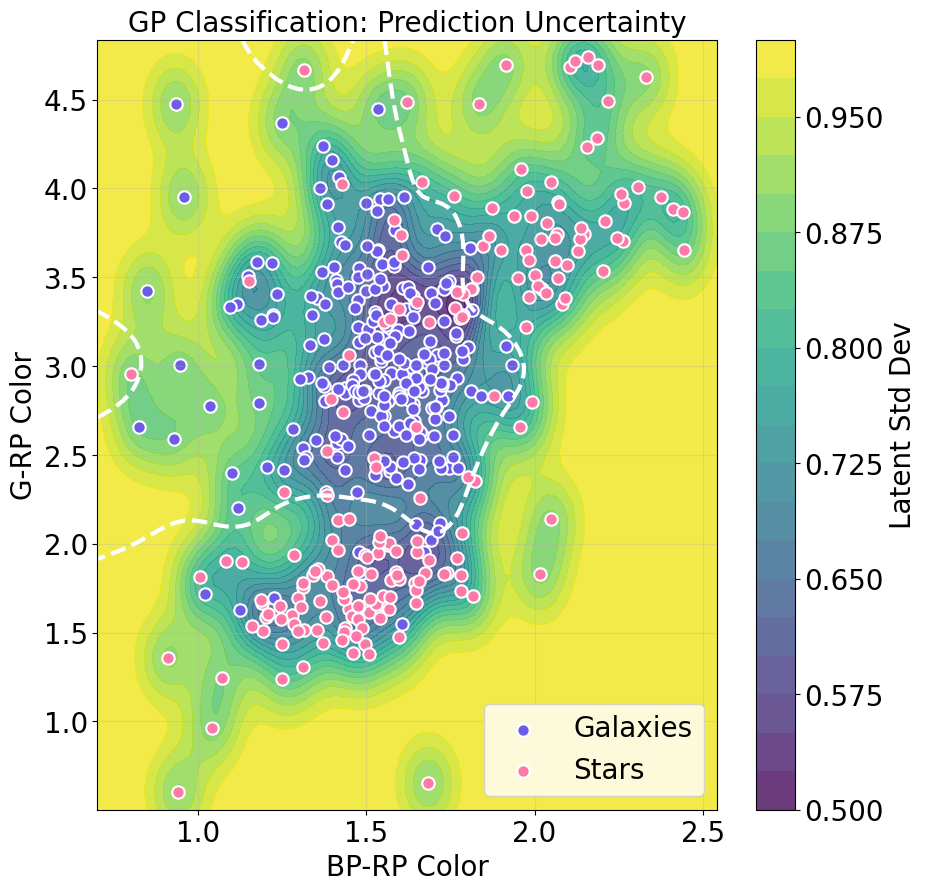

In [11]:
# Visualize prediction uncertainty
plt.figure(figsize=(10, 10))

# Plot uncertainty (standard deviation) in latent space
std_grid = np.sqrt(var_grid)
uncertainty = plt.contourf(bp_rp_grid, g_rp_grid, std_grid,
                         cmap='viridis', alpha=0.8, levels=20)
plt.colorbar(uncertainty, label='Latent Std Dev')

# Overlay training data
plt.scatter(X_train[t_train == 0, 0], X_train[t_train == 0, 1], 
           s=80, color=galaxy_color, alpha=1.0,
           edgecolors='white', linewidth=1.5, label='Galaxies')
plt.scatter(X_train[t_train == 1, 0], X_train[t_train == 1, 1], 
           s=80, color=star_color, alpha=1.0,
           edgecolors='white', linewidth=1.5, label='Stars')

# Draw decision boundary
plt.contour(bp_rp_grid, g_rp_grid, p_grid, 
           levels=[0.5], colors='white', linewidths=3, linestyles='dashed')

plt.xlabel('BP-RP Color')
plt.ylabel('G-RP Color')
plt.title('GP Classification: Prediction Uncertainty')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The uncertainty visualization reveals a key strength of Gaussian Process Classification: the model automatically quantifies its confidence based on the availability and distribution of training data.

Notice how uncertainty patterns follow an intuitive structure:

1. **Low uncertainty (dark blue)**: Regions densely populated with training examples, where the model has strong evidence for its predictions.

2. **High uncertainty (yellow)**: Areas far from any training data, where the model must extrapolate beyond its experience. This is precisely where we want the model to express caution.

3. **Moderate uncertainty (green)**: The transition zones between classes and regions with mixed populations. The uncertainty naturally increases near the decision boundary where classification is inherently ambiguous.

This uncertainty quantification has direct astronomical applications. Objects in high-uncertainty regions could be prioritized for spectroscopic follow-up, while those in low-uncertainty regions can be confidently used for statistical studies without additional observations.

Let's examine how this uncertainty affects individual predictions:

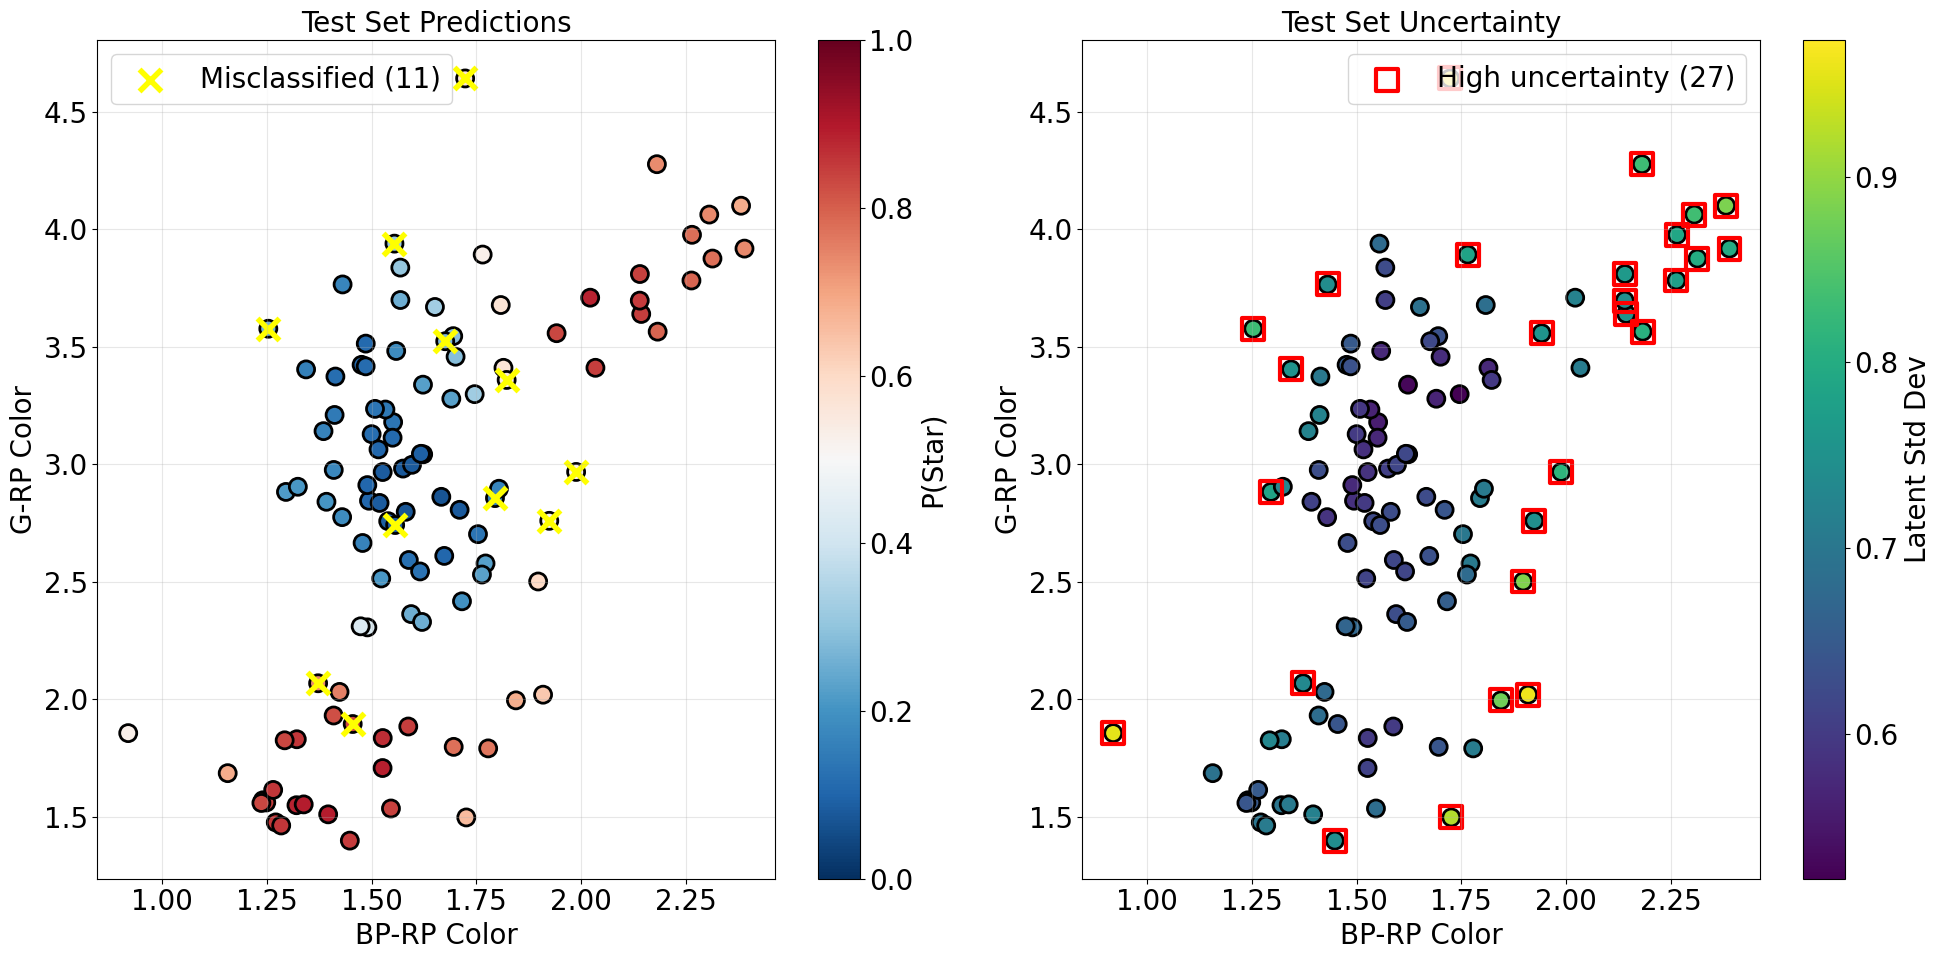

Misclassified objects: 11 out of 108
High uncertainty objects: 27 out of 108
Overlap (misclassified AND high uncertainty): 5


In [12]:
# Examine test set predictions with uncertainty
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Left panel: Test predictions colored by probability
ax = axes[0]
scatter = ax.scatter(X_test[:, 0], X_test[:, 1], 
                    c=p_test, cmap='RdBu_r', 
                    s=150, alpha=1.0, 
                    edgecolors='black', linewidth=2,
                    vmin=0, vmax=1)
plt.colorbar(scatter, ax=ax, label='P(Star)')

# Mark misclassified points
misclassified = t_pred != t_test
ax.scatter(X_test[misclassified, 0], X_test[misclassified, 1],
          s=250, marker='x', color='yellow', linewidth=4,
          label=f'Misclassified ({np.sum(misclassified)})')

ax.set_xlabel('BP-RP Color')
ax.set_ylabel('G-RP Color')
ax.set_title('Test Set Predictions')
ax.legend()
ax.grid(True, alpha=0.3)

# Right panel: Test predictions colored by uncertainty
ax = axes[1]
test_std = np.sqrt(var_test)
scatter = ax.scatter(X_test[:, 0], X_test[:, 1], 
                    c=test_std, cmap='viridis', 
                    s=150, alpha=1.0, 
                    edgecolors='black', linewidth=2)
plt.colorbar(scatter, ax=ax, label='Latent Std Dev')

# Highlight uncertain predictions (std > threshold)
uncertain = test_std > np.percentile(test_std, 75)
ax.scatter(X_test[uncertain, 0], X_test[uncertain, 1],
          s=250, marker='s', facecolors='none', edgecolors='red', linewidth=3,
          label=f'High uncertainty ({np.sum(uncertain)})')

ax.set_xlabel('BP-RP Color')
ax.set_ylabel('G-RP Color')
ax.set_title('Test Set Uncertainty')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print(f"Misclassified objects: {np.sum(misclassified)} out of {len(t_test)}")
print(f"High uncertainty objects: {np.sum(uncertain)} out of {len(t_test)}")
print(f"Overlap (misclassified AND high uncertainty): {np.sum(misclassified & uncertain)}")

## The Effect of Kernel Length Scale

The kernel length scale is a critical hyperparameter that controls the flexibility of the decision boundary. Let's examine how different length scales affect the classification:

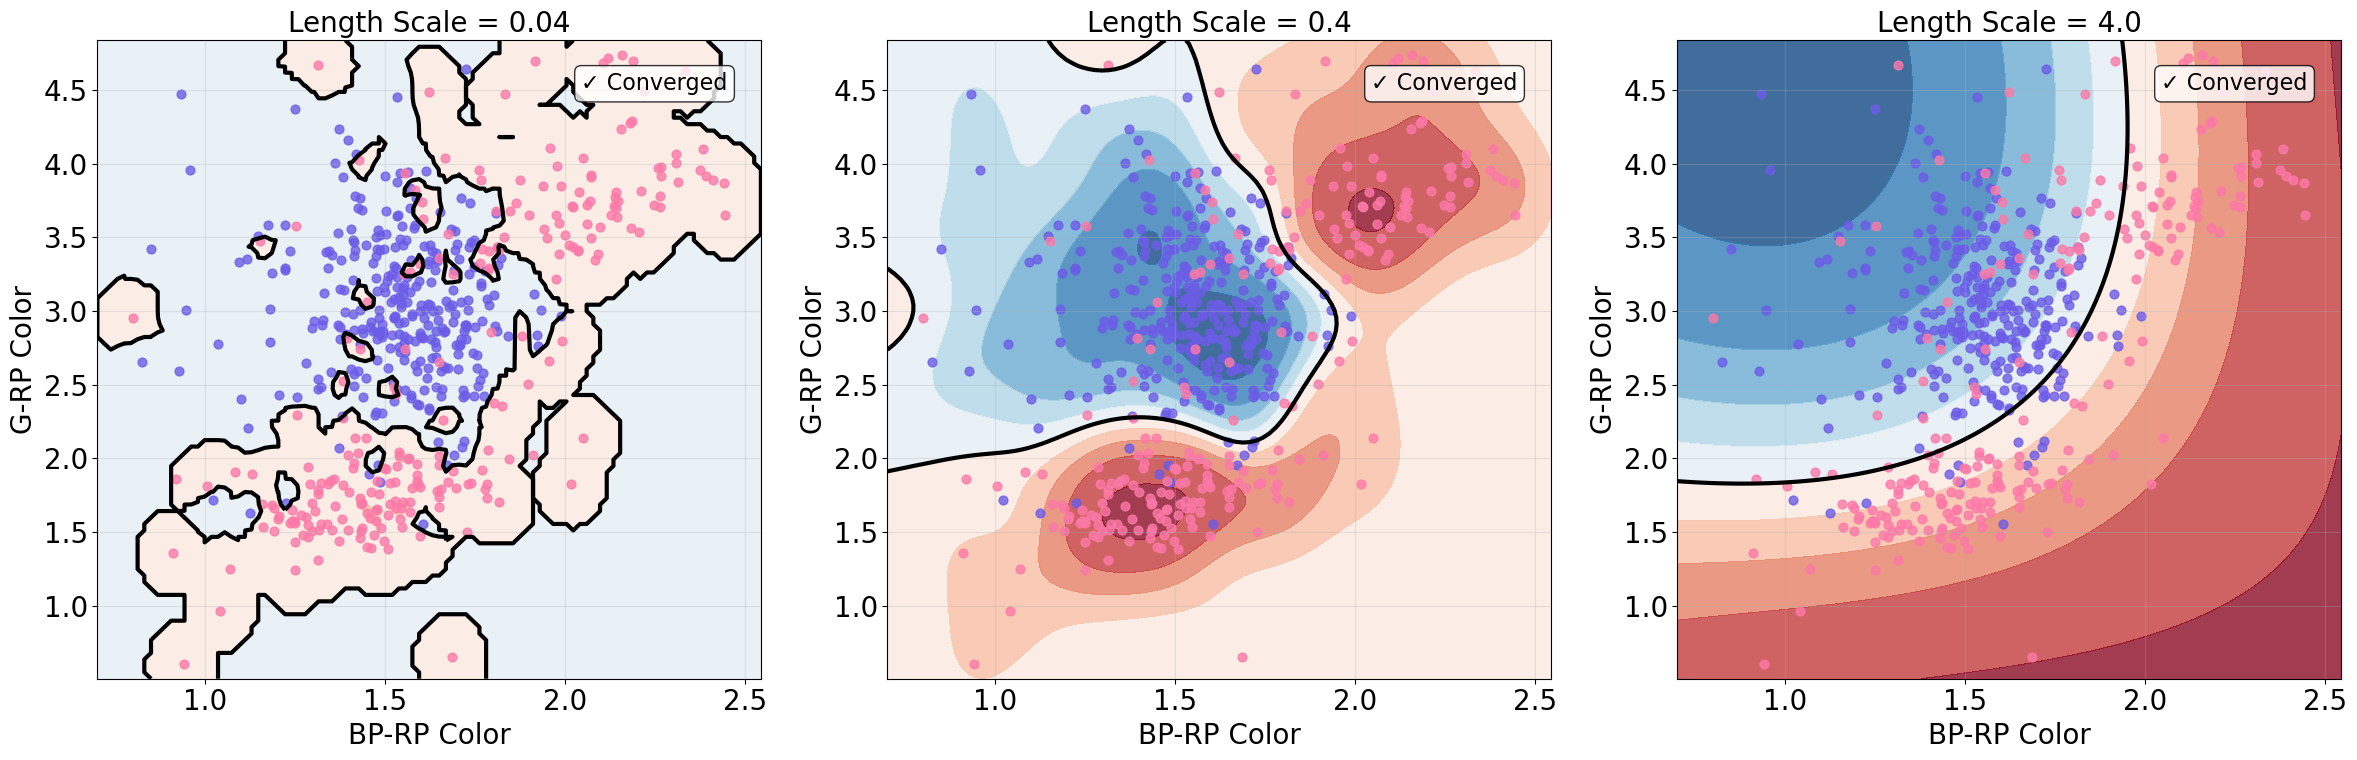

In [13]:
# Compare different length scales
length_scales = [0.04, 0.4, 4.0]
fig, axes = plt.subplots(1, 3, figsize=(24, 8))

for i, ls in enumerate(length_scales):
    # Train with different length scale
    K_train_ls = rbf_kernel(X_train_norm, X_train_norm, length_scale=ls, amplitude=1.0)
    a_map_ls, converged = find_map_estimate_damped(K_train_ls, t_train, 
                                                   damping=0.01, max_iter=5000)
    
    # Create normalized grid
    X_grid_norm = (X_grid - X_mean) / X_std
    
    # Predict on grid
    mu_grid_ls, var_grid_ls, p_grid_ls = predict_gpc(
        X_train_norm, t_train, X_grid_norm, a_map_ls, rbf_kernel,
        length_scale=ls, amplitude=1.0
    )
    p_grid_ls = p_grid_ls.reshape(n_grid, n_grid)
    
    # Plot
    ax = axes[i]
    contour = ax.contourf(bp_rp_grid, g_rp_grid, p_grid_ls,
                         levels=np.linspace(0, 1, 11), cmap='RdBu_r', alpha=0.8)
    
    # Decision boundary
    ax.contour(bp_rp_grid, g_rp_grid, p_grid_ls,
              levels=[0.5], colors='black', linewidths=3)
    
    # Data points (smaller for visibility)
    ax.scatter(X[t == 0, 0], X[t == 0, 1], s=40, color=galaxy_color, alpha=0.8)
    ax.scatter(X[t == 1, 0], X[t == 1, 1], s=40, color=star_color, alpha=0.8)
    
    ax.set_xlabel('BP-RP Color')
    ax.set_ylabel('G-RP Color')
    ax.set_title(f'Length Scale = {ls}')
    ax.grid(True, alpha=0.3)
    
    # Print convergence status
    status = "✓ Converged" if converged else "✗ Not converged"
    ax.text(0.95, 0.95, status, transform=ax.transAxes, 
            ha='right', va='top', fontsize=16,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


The comparison reveals how the kernel length scale fundamentally shapes the classifier's behavior:

1. **Very small length scale (0.04)**: Creates an extremely flexible model that can fit highly complex boundaries. The decision boundary shows severe overfitting, with numerous small islands and intricate curves that wrap tightly around individual training points. This extreme locality means each training example influences only its immediate neighborhood, leading to poor generalization.

2. **Optimal length scale (0.4)**: Strikes the right balance for this dataset. The boundary is smooth enough to generalize well while still capturing the genuine nonlinear separation between stars and galaxies. This length scale matches the natural scale of variation in the color space, allowing nearby points to share information effectively without oversmoothing the true structure.

3. **Large length scale (4.0)**: While convergence is achieved with appropriate damping, the resulting boundary is overly smooth and inflexible. The kernel enforces such strong correlations between distant points that the model cannot capture the local variations needed to properly separate the two populations. The boundary becomes almost linear, reverting to behavior similar to standard logistic regression.

This demonstrates a crucial principle in kernel methods: the length scale controls the bias-variance tradeoff. Too small leads to high variance (overfitting), while too large leads to high bias (underfitting). The optimal value depends on both the data distribution and the feature scaling, which is why we normalized our features before training.

## Selecting the Optimal Length Scale

The visualizations have shown us how different length scales dramatically affect the decision boundary—from overly complex wiggly boundaries with small length scales to overly smooth boundaries with large ones. But how do we systematically choose the best value? Visual inspection can guide us, but we need a principled approach for selecting hyperparameters.

Cross-validation provides exactly such a framework. The idea is to evaluate each length scale by training on subsets of the data and testing on held-out portions. This simulates how well the model would perform on genuinely new observations, helping us avoid both overfitting (choosing too small a length scale) and underfitting (choosing too large a length scale).

In principle, we could jointly optimize over both the length scale and amplitude parameters in our RBF kernel. However, for clarity and computational efficiency, we'll focus solely on optimizing the length scale while keeping the amplitude fixed at 1.0.

For GP classification, cross-validation is particularly important because:

1. **No closed-form marginal likelihood**: Unlike GP regression where we can analytically compute the marginal likelihood for hyperparameter optimization, the non-Gaussian likelihood in classification prevents this elegant solution.

2. **Convergence considerations**: As we've seen, some length scales prevent the MAP estimation from converging. Cross-validation naturally penalizes these problematic values.

3. **Generalization assessment**: The true test of a classifier is how well it performs on new data. Cross-validation estimates this generalization performance using only the training data.

In [14]:
from sklearn.model_selection import KFold

def cross_validate_gpc(X, t, length_scales, n_folds=5):
    """
    Perform cross-validation to select optimal length scale.
    
    Parameters
    ----------
    X : array
        Feature matrix
    t : array
        Target labels
    length_scales : array
        Length scales to evaluate
    n_folds : int
        Number of cross-validation folds
        
    Returns
    -------
    cv_scores : array
        Mean accuracy for each length scale
    cv_std : array
        Standard deviation of accuracy across folds
    """
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
    cv_scores = []
    cv_std = []
    
    for ls in length_scales:
        fold_scores = []
        
        for train_idx, val_idx in kf.split(X):
            # Split and normalize data
            X_train_cv = X[train_idx]
            X_val_cv = X[val_idx]
            t_train_cv = t[train_idx]
            t_val_cv = t[val_idx]
            
            # Normalize
            mean_cv = X_train_cv.mean(axis=0)
            std_cv = X_train_cv.std(axis=0)
            X_train_norm_cv = (X_train_cv - mean_cv) / std_cv
            X_val_norm_cv = (X_val_cv - mean_cv) / std_cv
            
            # Train model
            K_cv = rbf_kernel(X_train_norm_cv, X_train_norm_cv, ls, 1.0)
            a_map_cv, converged = find_map_estimate_damped(K_cv, t_train_cv, 
                                                          damping=0.01, max_iter=5000)
            
            if converged:
                # Make predictions
                _, _, p_val = predict_gpc(X_train_norm_cv, t_train_cv, X_val_norm_cv, 
                                        a_map_cv, rbf_kernel, ls, 1.0)
                accuracy = np.mean((p_val > 0.5) == t_val_cv)
            else:
                accuracy = 0.0  # Penalize non-convergence
                
            fold_scores.append(accuracy)
        
        cv_scores.append(np.mean(fold_scores))
        cv_std.append(np.std(fold_scores))
        print(f"Length scale {ls:.2f}: {np.mean(fold_scores):.3f} ± {np.std(fold_scores):.3f}")
    
    return np.array(cv_scores), np.array(cv_std)

# Test a range of length scales
length_scales_cv = np.logspace(-1.5, 0.5, 10)
print("Performing cross-validation...")
cv_scores, cv_std = cross_validate_gpc(X, t, length_scales_cv, n_folds=5)

Performing cross-validation...
Length scale 0.03: 0.823 ± 0.041
Length scale 0.05: 0.857 ± 0.042
Length scale 0.09: 0.871 ± 0.045
Length scale 0.15: 0.888 ± 0.047
Length scale 0.24: 0.888 ± 0.050
Length scale 0.41: 0.890 ± 0.050
Length scale 0.68: 0.886 ± 0.046
Length scale 1.14: 0.888 ± 0.057
Length scale 1.90: 0.879 ± 0.038
Length scale 3.16: 0.877 ± 0.023


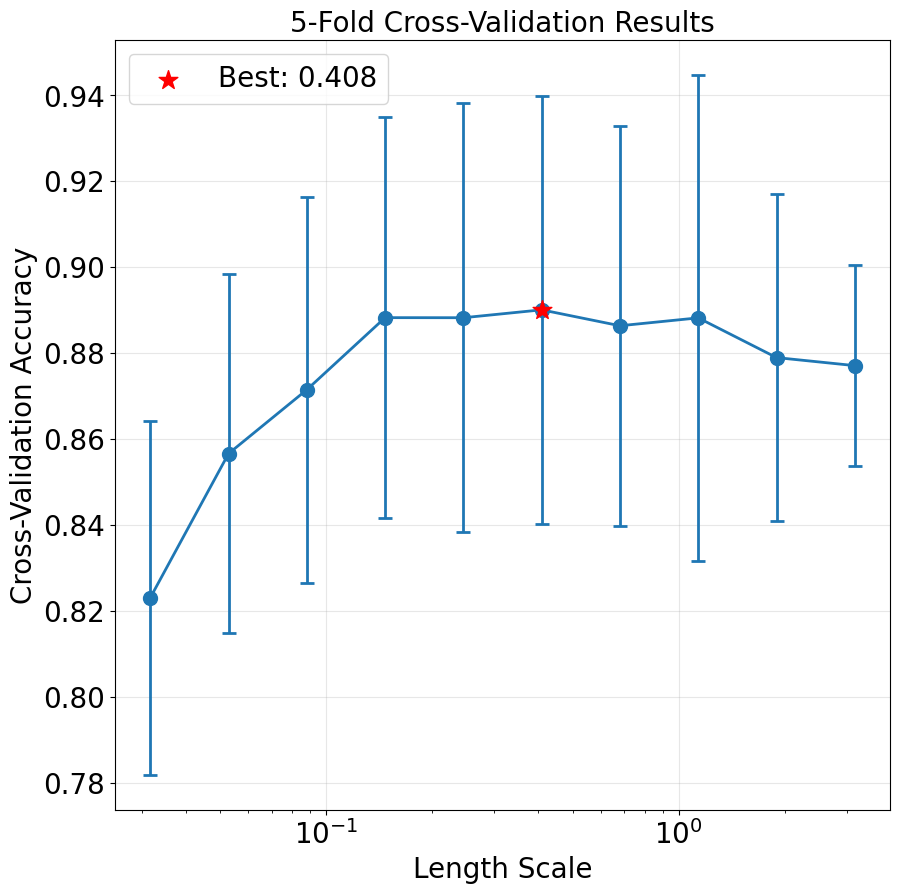


Optimal length scale: 0.408
Cross-validation accuracy: 0.890 ± 0.050


In [15]:
# Visualize cross-validation results
plt.figure(figsize=(10, 10))

plt.errorbar(length_scales_cv, cv_scores, yerr=cv_std, 
             fmt='o-', markersize=10, capsize=5, capthick=2, linewidth=2)

# Mark the best length scale
best_idx = np.argmax(cv_scores)
best_ls = length_scales_cv[best_idx]
best_score = cv_scores[best_idx]

plt.scatter([best_ls], [best_score], color='red', s=200, marker='*', 
           zorder=5, label=f'Best: {best_ls:.3f}')

plt.xscale('log')
plt.xlabel('Length Scale')
plt.ylabel('Cross-Validation Accuracy')
plt.title('5-Fold Cross-Validation Results')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print(f"\nOptimal length scale: {best_ls:.3f}")
print(f"Cross-validation accuracy: {best_score:.3f} ± {cv_std[best_idx]:.3f}")

The cross-validation results reveal a clear pattern in how length scale affects classification performance:

1. **Poor performance at small length scales** (< 0.1): The accuracy is lowest for very small length scales, confirming our visual observation of overfitting. The large error bars indicate high variability across folds—the model is fitting noise patterns that don't generalize consistently.

2. **Optimal performance plateau** (0.2 - 1.0): The accuracy reaches a plateau around length scale 0.4, with the optimal value at 0.408 achieving approximately 89% accuracy. This matches our visual assessment that length scales in this range provide good balance between flexibility and smoothness.

3. **Slight decline at large length scales** (> 1.0): Performance degrades slightly as the length scale becomes very large, though not as dramatically as with very small values. The model becomes too rigid to capture the nonlinear boundary effectively.

Let's now train our final model using the optimal length scale and evaluate its performance:

In [16]:
# Train final model with optimal length scale
print(f"Training final model with optimal length scale: {best_ls:.3f}")

# Use the full normalized training data
K_final = rbf_kernel(X_train_norm, X_train_norm, best_ls, 1.0)
a_map_final, converged = find_map_estimate_damped(K_final, t_train, 
                                                  damping=0.01, max_iter=5000)

if converged:
    print("Final model converged successfully")
else:
    print("Warning: Final model did not converge")

# Evaluate on test set
mu_test_final, var_test_final, p_test_final = predict_gpc(
    X_train_norm, t_train, X_test_norm, a_map_final, rbf_kernel,
    best_ls, 1.0
)

# Compute final metrics
t_pred_final = (p_test_final > 0.5).astype(int)
accuracy_final = np.mean(t_pred_final == t_test)

# Compute metrics for each class
stars_correct = np.sum((t_pred_final == 1) & (t_test == 1))
stars_total = np.sum(t_test == 1)
galaxies_correct = np.sum((t_pred_final == 0) & (t_test == 0))
galaxies_total = np.sum(t_test == 0)

print(f"\nFinal Test Set Performance:")
print(f"Overall accuracy: {accuracy_final:.3f}")
print(f"Star classification: {stars_correct}/{stars_total} ({100*stars_correct/stars_total:.1f}%)")
print(f"Galaxy classification: {galaxies_correct}/{galaxies_total} ({100*galaxies_correct/galaxies_total:.1f}%)")
print(f"\nComparison:")
print(f"Logistic Regression accuracy: {lr_accuracy:.3f}")
print(f"GP Classification accuracy: {accuracy_final:.3f}")
print(f"Improvement: +{100*(accuracy_final - lr_accuracy):.1f}%")

Training final model with optimal length scale: 0.408
Final model converged successfully

Final Test Set Performance:
Overall accuracy: 0.907
Star classification: 43/48 (89.6%)
Galaxy classification: 55/60 (91.7%)

Comparison:
Logistic Regression accuracy: 0.759
GP Classification accuracy: 0.907
Improvement: +14.8%


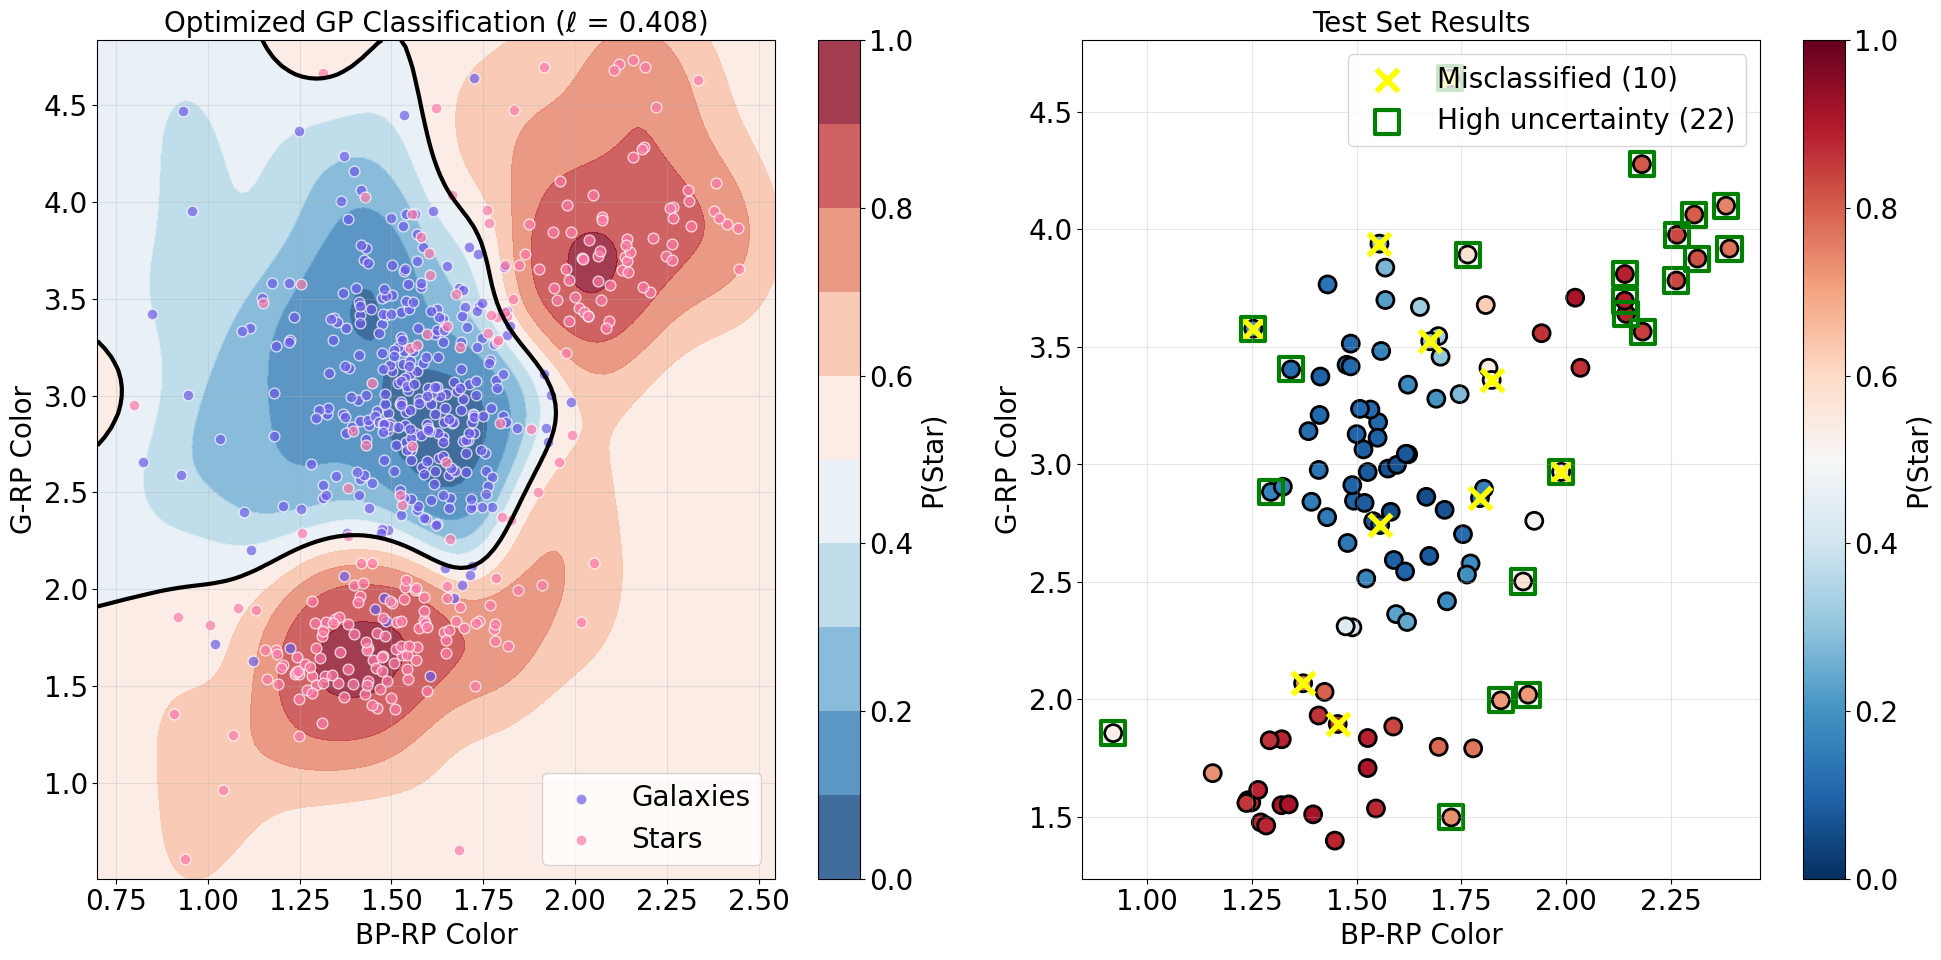

In [17]:
# Create final visualization with optimal model
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Recompute predictions on grid with optimal model
mu_grid_final, var_grid_final, p_grid_final = predict_gpc(
    X_train_norm, t_train, X_grid_norm, a_map_final, rbf_kernel, 
    best_ls, 1.0
)
p_grid_final = p_grid_final.reshape(n_grid, n_grid)
var_grid_final = var_grid_final.reshape(n_grid, n_grid)

# Left panel: Final predictions
ax = axes[0]
contour = ax.contourf(bp_rp_grid, g_rp_grid, p_grid_final, 
                      levels=np.linspace(0, 1, 11), 
                      cmap='RdBu_r', alpha=0.8)
plt.colorbar(contour, ax=ax, label='P(Star)')

# Plot all data points
ax.scatter(X[t == 0, 0], X[t == 0, 1], 
          s=60, color=galaxy_color, alpha=0.7,
          edgecolors='white', linewidth=1, label='Galaxies')
ax.scatter(X[t == 1, 0], X[t == 1, 1], 
          s=60, color=star_color, alpha=0.7,
          edgecolors='white', linewidth=1, label='Stars')

# Decision boundary
ax.contour(bp_rp_grid, g_rp_grid, p_grid_final, 
          levels=[0.5], colors='black', linewidths=3)

ax.set_xlabel('BP-RP Color')
ax.set_ylabel('G-RP Color')
ax.set_title(f'Optimized GP Classification (ℓ = {best_ls:.3f})')
ax.legend()
ax.grid(True, alpha=0.3)

# Right panel: Test set predictions with uncertainty
ax = axes[1]
test_std_final = np.sqrt(var_test_final)

# Create custom colormap for probabilities
scatter = ax.scatter(X_test[:, 0], X_test[:, 1], 
                    c=p_test_final, cmap='RdBu_r',
                    s=150, alpha=1.0,
                    edgecolors='black', linewidth=2,
                    vmin=0, vmax=1)
plt.colorbar(scatter, ax=ax, label='P(Star)')

# Highlight misclassified points
misclassified_final = t_pred_final != t_test
ax.scatter(X_test[misclassified_final, 0], X_test[misclassified_final, 1],
          s=250, marker='x', color='yellow', linewidth=4,
          label=f'Misclassified ({np.sum(misclassified_final)})')

# Mark high uncertainty points
high_uncertainty = test_std_final > np.percentile(test_std_final, 80)
ax.scatter(X_test[high_uncertainty, 0], X_test[high_uncertainty, 1],
          s=300, marker='s', facecolors='none', 
          edgecolors='green', linewidth=3,
          label=f'High uncertainty ({np.sum(high_uncertainty)})')

ax.set_xlabel('BP-RP Color')
ax.set_ylabel('G-RP Color')
ax.set_title('Test Set Results')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Summary

In this tutorial, we've explored Gaussian Process Classification through the practical lens of star-galaxy separation using Gaia photometric colors. The journey from linear to nonlinear classification has revealed several key insights about this powerful framework.

**From Linear Boundaries to Flexible Decision Surfaces**: We began by demonstrating the limitations of logistic regression, which forces a linear decision boundary through our color space. GP classification transcends this limitation by placing a Gaussian Process prior on a latent function, enabling the model to learn complex, nonlinear boundaries that adapt to the true structure of the data.

**The Computational Challenge and Solution**: Unlike GP regression, the discrete nature of classification labels breaks the convenient conjugacy properties. We addressed this through:
- The Laplace approximation to handle the non-Gaussian posterior
- Damped fixed-point iteration for stable MAP estimation  
- The probit approximation for tractable predictive distributions

**Hyperparameter Selection Matters**: The kernel length scale emerged as a critical parameter controlling the bias-variance tradeoff. Through systematic cross-validation, we discovered the importance of matching the length scale to the problem's intrinsic scale—too small leads to overfitting with erratic boundaries, too large produces underfitting with excessive smoothness. The optimal value balances flexibility with generalization.

The improvement over logistic regression—while modest in raw accuracy—comes with the crucial benefit of knowing when the model is uncertain. For astronomical applications, a classifier that can identify ambiguous cases for spectroscopic follow-up is far more valuable than one that makes overconfident errors.

This framework extends naturally to more complex scenarios: multi-class classification for spectral typing, higher-dimensional feature spaces from multi-band photometry, or incorporating measurement uncertainties directly into the kernel function. The mathematical foundations we've developed here provide the basis for tackling these more sophisticated challenges in astronomical classification.